# Alpha Shapes  

<hr>

## Imports

In [1]:
import open3d as o3d
from open3d.visualization import draw_geometries as draw
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import copy as copy

%matplotlib inline

## Build Cylinder

In [3]:
# generate cylinder
height = 10.0
radius = 0.25
# cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius, height, 5000, 10000)
cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius, height)

# calculate surface area of cylinder
cylinder_surf_area = cylinder.get_surface_area()
print(f"Surface Area: {cylinder_surf_area}")

# sample points from cylinder to recreate point cloud
cylinder_pc = cylinder.sample_points_uniformly(300)

# draw cylinder point cloud
# draw([cylinder_pc])

Surface Area: 16.029717746991814


## Get Alpha Shape and Surface Area for varying alpha value from 0.1 to 1 by steps of 0.1

0.023853097001799016
CPU time: 0.014480113983154297
6.221242358184717
CPU time: 0.014323949813842773
14.755901490753677
CPU time: 0.01469731330871582
14.88589868456699
CPU time: 0.012962102890014648
14.945240335533303
CPU time: 0.012643098831176758
15.001627162858753
CPU time: 0.012042999267578125
15.023872012738375
CPU time: 0.01207876205444336
15.04238088393954
CPU time: 0.011488914489746094
15.054282188137526
CPU time: 0.01158285140991211
15.097293639579414
CPU time: 0.011529922485351562


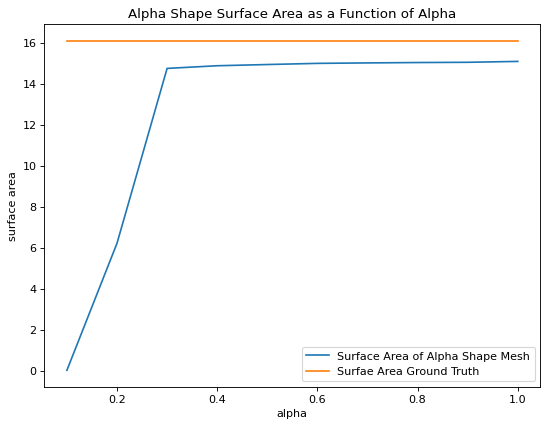

In [16]:
# create sequence of alphas from 0.1 to 1 by steps of 0.1
alphas = [alpha for alpha in np.arange(0.1, 1.1, 0.1)]

# empty surface area list to append to
surface_areas = []

cpu_times = []
# loop to calculate surface area for each alpha
for alpha in alphas:
    # get mesh using current alpha
    start = time.time()
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(cylinder_pc, alpha)
    stop = time.time()
    
    # get cpu time for meshing
    taken = stop - start
    
    
    # calculate and store surface area of resulting alpha shape mesh
    surf_area = mesh.get_surface_area()
    surface_areas.append(surf_area)    
    print(surf_area)
    print(f"CPU time: {taken}")
    cpu_times.append(taken)

#     plot the resulting mesh
#     draw([mesh])

# initiate plot and set size
figure(figsize=(8, 6), dpi=80)
# plot results of surface area as a function of alpha values
plt.plot(alphas, surface_areas, label="Surface Area of Alpha Shape Mesh")
# plot line representing ground truth surface area
plt.plot(alphas, [16.10066 for i in range(len(alphas))], label="Surfae Area Ground Truth")
plt.title("Alpha Shape Surface Area as a Function of Alpha")
plt.xlabel("alpha")
plt.ylabel("surface area")
plt.legend()
plt.show()





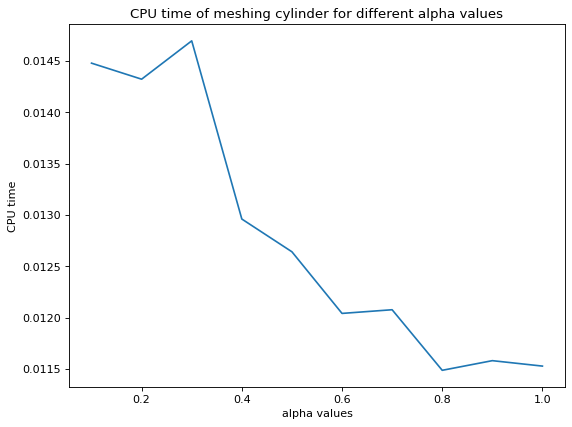

In [17]:
# make plot of cpu times as a function of alpha value
figure(figsize=(8, 6), dpi=80)
plt.plot(alphas, cpu_times)
plt.title("CPU time of meshing cylinder for different alpha values")
plt.xlabel("alpha values")
plt.ylabel("CPU time")
plt.show()

Iteration: 0, density: 100, surf area: 8.654110845254513
Iteration: 1, density: 200, surf area: 14.599807274752262


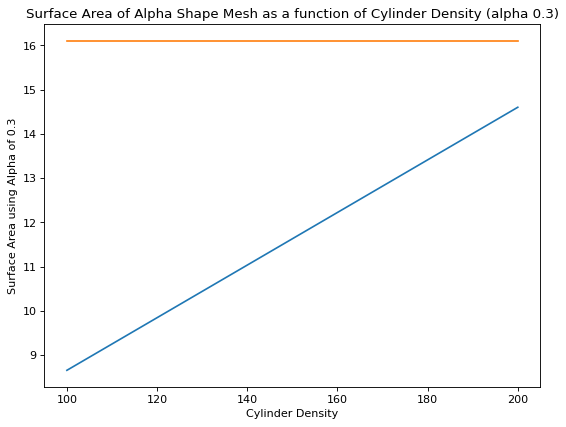

In [21]:
dens = np.arange(100, 300, 100)

alpha = 0.3

num_dens = len(dens)
ground_truth = [16.10066 for x in range(num_dens)]

i = 0
density = 1000
surf_area_dens = []
while i < num_dens:
    # get cylinder point cloud for current density then mesh
    cylinder_pc = cylinder.sample_points_uniformly(dens[i])
    try:
        mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(cylinder_pc, alpha)
        print(f"Iteration: {i}, density: {dens[i]}, surf area: {mesh.get_surface_area()}")
        surf_area_dens.append(mesh.get_surface_area())
    except:
        # don't update i need to redo cylinder point cloud
#         print("need to redo, don't update i")
        pass
    else:
        # cylinder point cloud did not result in tetra mesh problem, move to next density
        i += 1    
    
#     draw([mesh], window_name=str(density))


# print(surf_area_dens)

figure(figsize=(8, 6), dpi=80)
plt.plot(dens, surf_area_dens, label="Surface Area at Density")
plt.plot(dens, ground_truth, label="Cylinder Surface Area Ground Truth")
plt.title("Surface Area of Alpha Shape Mesh as a function of Cylinder Density (alpha 0.3)")
plt.xlabel("Cylinder Density")
plt.ylabel("Surface Area using Alpha of 0.3")
plt.show()

In [ ]:
draw([cylinder_pc])

# Alpha shape geometry analysis

In [22]:
# file = "/Users/hackattendant/Desktop/FuelsCraft/Tree_point_cloud.ply"
file = "/Users/hackattendant/Desktop/FuelsCraft/R_Meshing_Playground/other_r_m_pg/Tree-normals.xyz"
tree_pc = o3d.io.read_point_cloud(file)

In [ ]:
# tree_pc.normals = o3d.utility.Vector3dVector()
# tree_pc.has_normals()

In [23]:
tree_down = tree_pc.voxel_down_sample(0.05)

In [ ]:
alphas = np.arange(0.1, 1.1, 0.1)

for alpha in alphas:
    mesh =  o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(tree_down, alpha)
    mesh.paint_uniform_color(np.array([0.2, 0.8, 0.1]))
    draw([mesh], window_name=str(alpha))

# Ball pivoting algorithm

In [24]:
cylinder_tri_bpa = copy.copy(cylinder)

In [ ]:
radii = [0.2, 0.4, 0.6, 0.8]

In [ ]:
down_cylinder = cylinder_tri_bpa.sample_points_poisson_disk(2000)

In [ ]:
down_cylinder.estimate_normals()
down_cylinder.orient_normals_consistent_tangent_plane(1)

In [ ]:
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(down_cylinder, o3d.utility.DoubleVector([0.2, 0.4, 0.6, 0.8]))

In [ ]:
mesh.get_surface_area()

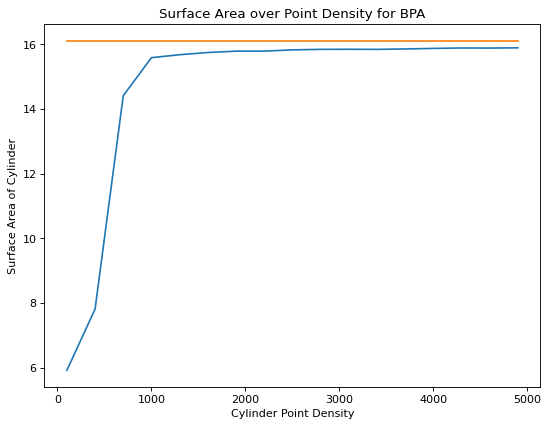

In [38]:
cylinder_tri_bpa = copy.copy(cylinder)

densities = [x for x in range(100, 5000, 300)]
radii = o3d.utility.DoubleVector([0.2, 0.4, 0.6, 0.8])

surface_areas_bpa = []
times = []

for density in densities:
    # get cylinder of current density
    cylinder_w_dens = cylinder_tri_bpa.sample_points_uniformly(density)
    cylinder_w_dens.estimate_normals()
    cylinder_w_dens.orient_normals_consistent_tangent_plane(1)
    
    # mesh with current density
    start = time.time()
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(cylinder_w_dens, radii)
    stop = time.time()
    time_taken = stop - start
    times.append(time_taken)
    # visualize for plot of resulting meshes
    draw([mesh], window_name=str(density))
    
    # add surface area
    surface_areas_bpa.append(mesh.get_surface_area())

figure(figsize=(8, 6), dpi=80)
plt.plot(densities, surface_areas_bpa, label="Surface Area at Density")
plt.plot(densities, [16.1066 for x in range(len(densities))], label="Ground Truth Density (16.10066)")
plt.title("Surface Area over Point Density for BPA")
plt.xlabel("Cylinder Point Density")
plt.ylabel("Surface Area of Cylinder")
plt.show()

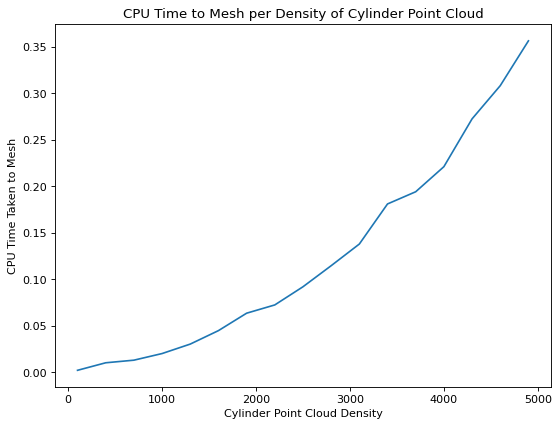

In [41]:
figure(figsize=(8, 6), dpi=80)
plt.plot(densities, times)
plt.title("CPU Time to Mesh per Density of Cylinder Point Cloud")
plt.xlabel("Cylinder Point Cloud Density")
plt.ylabel("CPU Time Taken to Mesh")
plt.show()

In [34]:
surface_areas_bpa

[5.6093664096146405,
 7.918639275843575,
 14.980537118576471,
 15.654697778303964,
 15.707037008287992,
 15.744714699412127,
 15.768897341637345,
 15.78355631170477,
 15.814545249606818,
 15.831352443793673,
 15.846431235293977,
 15.835296406828212,
 15.844020182684798,
 15.870628616003446,
 15.875194160417701,
 15.881663616069465,
 15.877595427208815]

In [36]:
densities

[100,
 400,
 700,
 1000,
 1300,
 1600,
 1900,
 2200,
 2500,
 2800,
 3100,
 3400,
 3700,
 4000,
 4300,
 4600,
 4900]

# Poisson

In [71]:
file = "/Users/hackattendant/Desktop/FuelsCraft/DEV/FuelsCraft/Data/Tree_point_cloud.ply"
tree_pc = o3d.io.read_point_cloud(file)
depths = [x for x in range(2, 12)]
times = []

for depth in depths:
    start = time.time()
    mesh, dens = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(tree_pc, depth=depth)
    stop = time.time()
    taken = stop - start
    times.append(taken)
    print(f"depth: {depth}; time: {taken}")
    
    densities = np.asarray(dens)
    density_colors = plt.get_cmap('plasma')(
        (densities - densities.min()) / (densities.max() - densities.min()))
    density_colors = density_colors[:, :3]
    density_mesh = o3d.geometry.TriangleMesh()
    density_mesh.vertices = mesh.vertices
    density_mesh.triangles = mesh.triangles
    density_mesh.triangle_normals = mesh.triangle_normals
    density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)
    
    draw([density_mesh], window_name=str(depth), mesh_show_back_face=True, mesh_show_wireframe=True)



depth: 2; time: 0.12666702270507812
depth: 3; time: 0.16207170486450195
depth: 4; time: 0.22896885871887207
depth: 5; time: 0.27156496047973633
depth: 6; time: 0.3833651542663574
depth: 7; time: 0.7983191013336182
depth: 8; time: 2.665760040283203
depth: 9; time: 12.217893123626709
depth: 10; time: 43.08611297607422
depth: 11; time: 63.550678968429565


In [72]:
depths

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [73]:
times

[0.12666702270507812,
 0.16207170486450195,
 0.22896885871887207,
 0.27156496047973633,
 0.3833651542663574,
 0.7983191013336182,
 2.665760040283203,
 12.217893123626709,
 43.08611297607422,
 63.550678968429565]

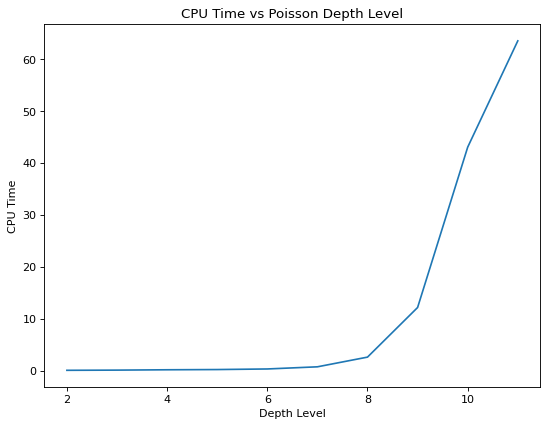

In [75]:
figure(figsize=(8, 6), dpi=80)
plt.plot(depths, times)
plt.title("CPU Time vs Poisson Depth Level")
plt.xlabel("Depth Level")
plt.ylabel("CPU Time")
plt.show()

depth: 2; time: 0.02262282371520996
31.330162044904945

depth: 3; time: 0.05340385437011719
25.137620743693237

depth: 4; time: 0.09048175811767578
18.388815071577756

depth: 5; time: 0.14112567901611328
17.440944086432424

depth: 6; time: 0.1735091209411621
15.594820951796331

depth: 7; time: 0.2374429702758789
15.905531246654768

depth: 8; time: 0.6101789474487305
15.952904000351442

depth: 9; time: 0.7198789119720459
15.951593804177866

depth: 10; time: 0.9135098457336426
15.955507696643572

depth: 11; time: 1.2887358665466309
15.955526233263143

depth: 12; time: 2.1164729595184326
15.955528011385436

depth: 13; time: 3.4809069633483887
15.955528342713805

depth: 14; time: 6.26256799697876
15.955528294611657

depth: 15; time: 11.677290916442871
15.95552839113012



Text(0.5, 1.0, 'Surface Area vs Poisson Depth Level for Cylinder Basis')

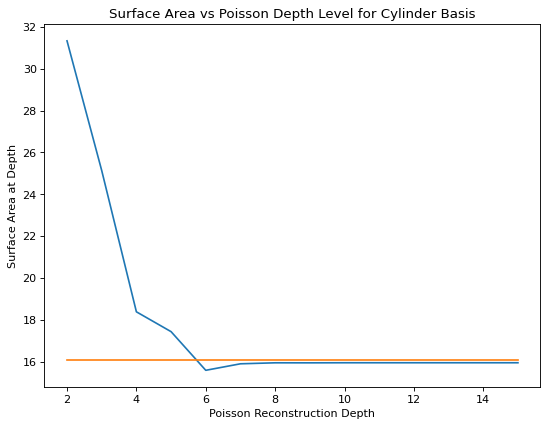

In [11]:
depths = [x for x in range(2, 16)]

cylinder_poisson_tri = copy.copy(cylinder)
# pull out cylinder point cloud
cylinder_pc = cylinder_poisson_tri.sample_points_uniformly(5000)
cylinder_pc.estimate_normals()
cylinder_pc.orient_normals_consistent_tangent_plane(1)
times = []
surf_area = []

for depth in depths:
    start = time.time()
    mesh, dens = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(cylinder_pc, depth=depth)
    stop = time.time()
    taken = stop - start
    times.append(taken)
    print(f"depth: {depth}; time: {taken}")
    
    densities = np.asarray(dens)
    density_colors = plt.get_cmap('plasma')(
        (densities - densities.min()) / (densities.max() - densities.min()))
    density_colors = density_colors[:, :3]
    density_mesh = o3d.geometry.TriangleMesh()
    density_mesh.vertices = mesh.vertices
    density_mesh.triangles = mesh.triangles
    density_mesh.triangle_normals = mesh.triangle_normals
    density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)
    
    surf_area_mesh = density_mesh.get_surface_area()
    surf_area.append(surf_area_mesh)
    print(surf_area_mesh)
    print()
    
#     draw([density_mesh], window_name=str(depth), mesh_show_back_face=True, mesh_show_wireframe=True)

figure(figsize=(8, 6), dpi=80)
# plot of surface area based on depth
plt.plot(depths, surf_area, label="Surface Area at Depth Level")
y = [16.1066 for x in range(len(depths))]
plt.plot(depths, y, label="Ground Truth Cylinder Surface Area")
plt.xlabel("Poisson Reconstruction Depth")
plt.ylabel("Surface Area at Depth")
plt.title("Surface Area vs Poisson Depth Level for Cylinder Basis")

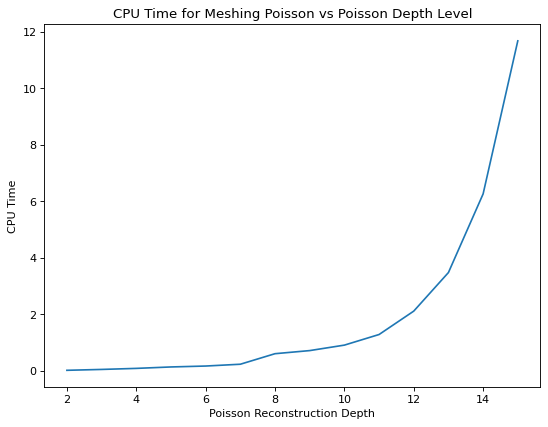

In [13]:
figure(figsize=(8, 6), dpi=80)
plt.title("CPU Time for Meshing Poisson vs Poisson Depth Level")
plt.xlabel("Poisson Reconstruction Depth")
plt.ylabel("CPU Time")
plt.plot(depths, times)
plt.show()

In [2]:
tree_pc = o3d.io.read_point_cloud("/Users/hackattendant/Desktop/FuelsCraft/DEV/FuelsCraft/Data/Tree_point_cloud.ply")

In [40]:
mesh, dens = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(tree_pc)

densities = np.asarray(dens)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = mesh.vertices
density_mesh.triangles = mesh.triangles
density_mesh.triangle_normals = mesh.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)
    
draw([density_mesh], mesh_show_wireframe=True)

In [41]:
density_mesh.get_surface_area()

33.255129803939596

In [42]:
dens_mesh_copy = copy.copy(density_mesh)
dens_copy = copy.copy(dens)
mesh_copy = copy.copy(mesh)

In [43]:
verts_to_remove = dens_copy < np.quantile(dens_copy, 0.11)
mesh_copy.remove_vertices_by_mask(verts_to_remove)
mesh_copy.paint_uniform_color([0, 1, 0])

draw([mesh_copy], window_name=str(mesh_copy.get_surface_area()))

In [48]:
tree_pc = o3d.io.read_point_cloud("/Users/hackattendant/Desktop/FuelsCraft/DEV/FuelsCraft/Data/Tree_point_cloud.ply")
mesh, dens = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(tree_pc)

surf_area_per_thresh = []

thres = [x for x in np.arange(0.01, 0.1, 0.01)]

for thresh in thres:
    # re copy each loop
    dens_mesh_copy = copy.copy(density_mesh)
    dens_copy = copy.copy(dens)
    mesh_copy = copy.copy(mesh)
    
    verts_to_remove = dens_copy < np.quantile(dens_copy, thresh)
    mesh_copy.remove_vertices_by_mask(verts_to_remove)
    mesh_copy.paint_uniform_color([0, 1, 0])
    
    surf_area = mesh_copy.get_surface_area()
    
    print(f"Threshold: {thresh}, Surface Area: {surf_area}")
    
    draw([mesh_copy], mesh_show_wireframe=True, mesh_show_back_face=True, window_name=str(thresh))

Threshold: 0.01, Surface Area: 23.33832751809999
Threshold: 0.02, Surface Area: 21.9011317824288
Threshold: 0.03, Surface Area: 21.462428625578767
Threshold: 0.04, Surface Area: 21.11355610435808
Threshold: 0.05, Surface Area: 20.81514877218638
Threshold: 0.060000000000000005, Surface Area: 20.515699836775468
Threshold: 0.06999999999999999, Surface Area: 20.251884209854133
Threshold: 0.08, Surface Area: 19.99721216154609
Threshold: 0.09, Surface Area: 19.740277287888123


In [49]:
dens_mesh_copy = copy.copy(density_mesh)
dens_copy = copy.copy(dens)
mesh_copy = copy.copy(mesh)

In [50]:
mesh, dens = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(tree_pc)

In [51]:
mesh.get_surface_area()

33.25513508086825

In [ ]:
mesh.paint_uniform_color([0,1,0])
draw([mesh], mesh_show_wireframe=True, mesh_show_back_face=True)